# Use single-copy data to extrapolated GME activation of three copies.

* The state is extrapolated using experimental single-copy (three-qubit) quantum state density matrices.
* Based on this extrapolated state we simulate the witness measurement with given number of shots.
* We evaluate mean and standard deviation of the obtained three-copy witness value.

In [9]:
# Import packages

#builtins
import itertools
from functools import reduce, cache, partial

#essentials
import numpy as np
import matplotlib.pyplot as plt
import h5py #to open data packs
import torch as tr

#non-essentials
from tqdm import tqdm # to show progressbars
tqdm = partial(tqdm, position=0, leave=True)

In [10]:
# Quantum mechanics helper functions and constants
# This has been in KetSugar.py, but it is moved here 
# for transparency.
# ------------------------------------

LO = np.array([[1],[0]])
HI = np.array([[0],[1]])
HLO = (LO+HI)*(2**-.5)
HHI = (LO-HI)*(2**-.5)
CLO = (LO+1j*HI)*(2**-.5)
CHI = (LO-1j*HI)*(2**-.5)

Sgate = np.array([[1, 0], [0, 1j]])
SI = np.eye(2)
SZ = np.diag([1,-1])
SX = np.array([[0,1],[1,0]])
SY = np.array([[0,-1j],[1j,0]])

#eigenvectors and eigenvalues of Pauli matrices
PAULI_EIGENBASE_DICT = {
    'I' : ((LO, HI), (1,1)),
    'X' : ((HLO, HHI), (1,-1)),
    'Y' : ((CLO, CHI),(1,-1)),
    'Z' : ((LO, HI), (1,-1)),
}

def dagger(x : np.ndarray) -> np.ndarray:
    """
    Hermite conjugation of x.
    """
    return x.T.conjugate()

def ketbra(x : np.ndarray, y : np.ndarray) -> np.ndarray:
    """
    Outer product of two ket-vectors -> C-matrix
    """
    return np.dot(x, y.T.conjugate())

def kron(*arrays) -> np.ndarray:
    """
    Multiple Kronecker (tensor) product.
    Multiplication is performed from left.    
    """
    E = np.eye(1, dtype=complex)
    for M in arrays:
        E = np.kron(E,M)
    return E

def BinKet(i : int = 0,imx : int =1) -> np.ndarray:
    """
    Computational base states i in imx+1-dimensional vectors.
    """
    ket = np.zeros((imx+1,1), dtype=complex)
    ket[i] = 1
    return ket

def ApplyOp(Rho : np.ndarray,M : np.ndarray) -> np.ndarray:
    """
    Calculate M.Rho.dagger(M).
    """
    return M @ Rho @ M.T.conjugate()

def ExpectationValue(Ket : np.ndarray, M : np.ndarray) -> np.ndarray:
    """
    Expectation value <bra|M|ket>.
    """
    return (Ket.T.conjugate() @ M @ Ket)[0,0]

@cache
def get_walsh_hadamard_vec(label : str) -> np.ndarray:
    """
    Get auxiliary vector for turning tomogram row into expectation value. Candidate for tabellation.
    """
    #eigenvalues of Pauli operators
    arr_map = {
        'X' : np.array([1,-1]),
        'Y' : np.array([1,-1]),
        'Z' : np.array([1,-1]),
        'I' : np.array([1,1])
    }
    return reduce(np.outer, [arr_map.get(c, np.eye(1)) for c in label]).ravel()
get_walsh_hadamard_vec.cache_clear()

@cache #cache calls to r
def base_string_to_proj(string : str) -> list:
    """
    Input measurement string and get projection operators corresponding to that string, 
    all combinations that can happen.    
    """    
    eigenvects = [PAULI_EIGENBASE_DICT[b][0] for b in string]
    proj_kets = [kron(*vecs) for i, vecs in enumerate(itertools.product(*eigenvects))]
    return proj_kets
base_string_to_proj.cache_clear()

def get_probabilities(rho : np.ndarray, base_str : str) -> np.ndarray:
    """Input density matrix and measurement string, and get array of probabilities ordered from 0..0 to 1..1"""
    #probs are ordered in increasing order of their binary representation
    probs = np.array([ExpectationValue(ket, rho).real for ket in base_string_to_proj(base_str)])
    return probs

In [14]:
# Define the states considered here
# ---------------------------
#Swap gates
def swap_ij(n : int, i : int, j : int) -> np.ndarray:
    """Generate swap matrix of qubits i,j in n-qubit space."""
    left_qubits = i
    central_qubits = (j - i) - 1
    right_qubits = (n - j) - 1
    eye_left = np.eye(1 << left_qubits)
    eye_center = np.eye(1 << central_qubits)
    eye_right = np.eye(1 << right_qubits)    
    ket_01 = kron(eye_left, LO, eye_center, HI, eye_right)
    ket_10 = kron(eye_left, HI, eye_center, LO, eye_right)
    bra_01 = dagger(ket_01)
    bra_10 = dagger(ket_10)
    swap = np.eye(1 << n, dtype=complex) \
        - ket_01 @ bra_01 - ket_10 @ bra_10 \
        + ket_01 @ bra_10 + ket_10 @ bra_01
    return swap

#operator that does this swap: abcabc -> aabbcc
swap_abc = swap_ij(6,3,4) @ swap_ij(6,1,2) @ swap_ij(6,2,3)

prep_gate = kron(Sgate, Sgate, SZ)
bellp = (BinKet(0b00, 3) + BinKet(0b11, 3))/np.sqrt(2)
bellm = (BinKet(0b00, 3) - BinKet(0b11, 3))/np.sqrt(2)
bell02p = (BinKet(0b000, 7) + BinKet(0b101, 7)+BinKet(0b010, 7) + BinKet(0b111, 7))/2
bell02m = (BinKet(0b000, 7) - BinKet(0b101, 7)-BinKet(0b010, 7) + BinKet(0b111, 7))/2

#single-copy constituent states as ket vectors
theo_kets_3q = {
    'a1' : kron(HLO, bellp),
    'a2' : kron(HHI, bellm),
    'a3' : prep_gate @ kron(HLO, bellp),
    'a4' : prep_gate @ kron(HHI, bellm),
    'b1' : bell02p,
    'b2' : bell02m,
    'b3' : prep_gate @ bell02p,
    'b4' : prep_gate @ bell02m,
    'c1' : BinKet(0b001, 7),
    'c2' : BinKet(0b110, 7)
}

#single-copy constituent states as density matrices
theo_rhos_3q = {key : ketbra(ket, ket) for key, ket in theo_kets_3q.items()}
theo_kets_6q = {
    f'{key1},{key2}' :
    kron(theo_kets_3q.get(key2), theo_kets_3q.get(key1)) 
    for key1, key2 in itertools.product(theo_kets_3q.keys(), repeat=2)}

#two-copy constituent states
theo_rhos_6q = {key : ketbra(ket, ket) for key, ket in theo_kets_6q.items()}
theo_rhos_6q_swapped = {key : ApplyOp(rho, swap_abc) for key, rho in theo_rhos_6q.items()}

key_order = list(theo_rhos_6q_swapped.keys())

Q = 0.26 #absurd value, normal would be 0.05
weights_single_copy = np.array([(1-Q)/8]*8 + [Q/2]*2)

weights_two_copy = np.outer(weights_single_copy,weights_single_copy).ravel()
# # equivalent to
# def key_to_weight(key):
#     n = key.count('c')
#     if n==0:
#         return ((1-Q)**2)/64
#     if n==1:
#         return ((1-Q)*Q)/(8*2)
#     if n==2:
#         return Q*Q/4

In [15]:
# np.genfromtxt('witness_3copy_table.txt').shape
import pandas as pd
dframe = pd.read_csv('data/witness_3copy_table.txt', sep='\t')
print(dframe.keys())
mstrs3cpy = [m.replace(' ','')[::-1] for m in dframe[' MEAS '][63:]]
fullmstrs3cpy = [m.replace(' ','')[::-1] for m in dframe[' MEAS ']]
mstrs3cpy[0] = 'Z'*9
wwghst3cpy = np.array(dframe[' weight'])

Index(['#ID ', ' MEAS ', ' k ', ' weight'], dtype='object')


In [16]:
#extend 0.333 to 0.333... to compensate for the rounding in saved table
for i, w in enumerate(wwghst3cpy):
    if (abs(w)-0.333) < 1e-3:
        wwghst3cpy[i] = np.sign(w)*1/3

In [18]:
Q = 0.26 #0.05
weights_single_copy = np.array([(1-Q)/8]*8 + [Q/2]*2)
weights_two_copy = np.outer(weights_single_copy,weights_single_copy).ravel()

In [19]:
rth0 = theo_rhos_3q['a1'] + theo_rhos_3q['a2']  + theo_rhos_3q['a3'] + theo_rhos_3q['a4']
rth0 += theo_rhos_3q['b1'] + theo_rhos_3q['b2']  + theo_rhos_3q['b3'] + theo_rhos_3q['b4']
rth0 /= 8
rth0 = rth0*(1-Q) + Q*(theo_rhos_3q['c1'] + theo_rhos_3q['c2'])/2

In [20]:
swap_9q = swap_ij(9,5,7) @ swap_ij(9, 2,6) @ swap_ij(9, 1,3)
rth3cpy = ApplyOp(kron(rth0, rth0, rth0), swap_9q)
tomo3cpy = np.array([get_probabilities(rth3cpy, m) for m in fullmstrs3cpy])
walsh3cpy = np.array([get_walsh_hadamard_vec(m) for m in fullmstrs3cpy])
expvalth_3cpy = np.sum(tomo3cpy * walsh3cpy, axis=1)
wval3th = wwghst3cpy @ expvalth_3cpy
print(wval3th)

-0.43549333333333384


In [23]:
## Predict the value based on reconstructed density matrices
with h5py.File('data/reconstructed_three_qubit_states.h5', 'r') as h5:
    rhos_first_copy = np.array(h5['rho_024'])
    rhos_second_copy = np.array(h5['rho_531'])
    rho_first = np.sum(rhos_first_copy * weights_single_copy.reshape((-1,1,1)), axis=0)
    rho_second = np.sum(rhos_second_copy * weights_single_copy.reshape((-1,1,1)), axis=0)
    rhos_third_copy = rhos_first_copy #(rhos_first_copy + rhos_second_copy)/2
    #since we do not know, we take a mean
    rho_third = (rho_first+rho_second)*0.5

rho_extrapolated_3cpy = kron(rho_first, rho_second, rho_third)
rho_extr_3cpy_sw = (swap_9q @ rho_extrapolated_3cpy @ swap_9q)

In [25]:
import KetSugar as ks
ks.Fidelity(rho_extr_3cpy_sw, rth3cpy)
#theoretical to expolated state fidelity

0.9543098439256986

In [26]:
theo_rhos_3q_list = [theo_rhos_3q[key] for key in [f'a{i}' for i in range(1,5)]+[f'b{i}' for i in range(1,5)]+['c1','c2']]

### Create probability tables for ideal states

In [27]:
#simulate witness tomogram - with ideal states
## the following Torch code is equivalent to this code, but explicit python looping on CPU is slow
## instead we trade memory for speed and run the calculations on GPU
# big_prob_table = np.zeros((1000, 128, 512))
# #instead we do vectorization and run it using torch
# for (i, j, k) in tqdm(itertools.product(range(10), repeat=3), total=1000):
#     _big_index = (i*100 + j*10 + k)
#     _rho = kron(rhos_first_copy[i], rhos_first_copy[j], rhos_first_copy[k])
#     for l, m in enumerate(fullmstrs3cpy):
#         big_prob_table[_big_index, l, :] = get_probabilities(_rho, m)     
# np.save('_prob_table_cache.npy', big_prob_table)

with tr.no_grad():        
    # big_prob_table = np.zeros((1000, len(fullmstrs3cpy), 512), dtype=np.float32) #~500 MB
    big_prob_table_gpu_ideal = tr.zeros((1000, len(fullmstrs3cpy), 512), dtype=tr.float64, device='cuda')
    big_state_table_gpu_ideal = tr.zeros((1000, 512*512), dtype=tr.complex128, device='cuda')

    #prepare individual density matrices into a nice linearized table
    for (_i, _j, _k) in tqdm((itertools.product(range(10), repeat=3)), total=1000):
        _big_index = (_i*100 + _j*10 + _k)
        _rho = ApplyOp(kron(theo_rhos_3q_list[_i], theo_rhos_3q_list[_j], theo_rhos_3q_list[_k]), swap_9q)
        big_state_table_gpu_ideal[_big_index, :] = tr.from_numpy(_rho.ravel())

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.25it/s]


In [28]:
with tr.no_grad():   
    for mindex, mstring in tqdm(enumerate(fullmstrs3cpy), total=128):
        # print(mindex, mstring)
        #generate projection table    
        _proj_table = np.zeros((512*512,512), dtype=np.complex128) #2 GB of memory if using complex128
        #this is slow and could be optimized further, but meh
        for _i, ket in enumerate(base_string_to_proj(mstring)):
            _proj_table[:,_i] = (ket @ ket.T.conj()).T.ravel()
        _proj_table_gpu = tr.from_numpy(_proj_table).cuda()
        #and use it to predict probabilities on rho
        big_prob_table_gpu_ideal[:,mindex,:] = tr.matmul(big_state_table_gpu_ideal, _proj_table_gpu).real
#free GPU memory
del big_state_table_gpu_ideal

big_prob_table_cpu_ideal =  big_prob_table_gpu_ideal.cpu().numpy()
np.save('_cached_big_prob_table_ideal.npy', big_prob_table_cpu_ideal)    

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [06:16<00:00,  2.94s/it]


In [29]:
#free GPU memory
del big_prob_table_gpu_ideal

In [30]:
#use cache, if one does not have time to compute things again
big_prob_table_cpu_ideal = np.load('_cached_big_prob_table_ideal.npy')

### Create probability tables for experimental-based extrapolated states

In [31]:
with tr.no_grad():        
    big_prob_table_gpu = tr.zeros((1000, len(fullmstrs3cpy), 512), dtype=tr.float64, device='cuda')
    big_state_table_gpu = tr.zeros((1000, 512*512), dtype=tr.complex128, device='cuda')
    #prepare individual density matrices into a nice linearized table
    for (_i, _j, _k) in tqdm((itertools.product(range(10), repeat=3)), total=1000):
        _big_index = (_i*100 + _j*10 + _k)
        _rho = ApplyOp(kron(rhos_first_copy[_i], rhos_first_copy[_j], rhos_third_copy[_k]), swap_9q)
        big_state_table_gpu[_big_index, :] = tr.from_numpy(_rho.ravel())

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.77it/s]


In [32]:
with tr.no_grad():   
    for mindex, mstring in tqdm(enumerate(fullmstrs3cpy),total=128):
        #generate projection table    
        _proj_table = np.zeros((512*512,512), dtype=np.complex128)
        #this is slow and could be optimized further, but meh
        for _i, ket in enumerate(base_string_to_proj(mstring)):
            _proj_table[:,_i] = (ket @ ket.T.conj()).T.ravel()
        _proj_table_gpu = tr.from_numpy(_proj_table).cuda()
        #and use it to predict probabilities on rho
        big_prob_table_gpu[:,mindex,:] = tr.matmul(big_state_table_gpu, _proj_table_gpu).real

big_prob_table_cpu =  big_prob_table_gpu.cpu().numpy()
del big_state_table_gpu
del big_prob_table_gpu
np.save('_cached_big_prob_table.npy', big_prob_table_cpu)    

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [06:12<00:00,  2.91s/it]


In [33]:
weights_three_copies = (weights_single_copy.reshape((10,1,1)) * weights_single_copy.reshape((1,10,1)) * weights_single_copy.reshape((1,1,10))).ravel()

### Evaluate three-copy witness

In [41]:
# def selfnorm(arr):
#     return arr/np.sum(arr)

def sample_tomogram(shots, table, norm=True):
    new_tomo = np.zeros_like(table, dtype=np.float32)
    for i, subtable in enumerate(table):
        for j, line in enumerate(subtable):
            nline = np.clip(line.astype(np.float64),0,1)
            nline /= np.sum(nline)
            new_tomo[i,j] = np.random.multinomial(shots, nline)        
    if norm:
        new_tomo /= np.sum(new_tomo, axis=2).reshape((table.shape[0], table.shape[1], 1))
    return new_tomo

def process_tomo(tomo):
    wghtd_tomo = np.sum(tomo * weights_three_copies.reshape((1000,1,1)), axis=0)
    expval = np.sum(wghtd_tomo * walsh3cpy, axis=1)
    return wwghst3cpy @ expval
    

In [42]:
# ideal states, many shots, 1 monte carlo sample
monte_carlo_samples = 1
shots = 512*1000
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu_ideal, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]

-0.43547314889903826
0.0
-0.43547314889903826
-0.43547314889903826


In [43]:
# reconstructed states, many shots, 1 monte carlo sample
monte_carlo_samples = 1
shots = 512*1000
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]

-0.03499344676545468
0.0
-0.03499344676545468
-0.03499344676545468


In [44]:
# reconstructed states, 50 shots per state and meas, 100 monte carlo sample
monte_carlo_samples = 100
shots = 50
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [07:22<00:00,  4.43s/it]

-0.03618164667684747
0.020796592032525405
-0.0903861128572429
0.0031659523461294303


(array([ 2.,  3., 10.,  7., 11., 12., 17., 26.,  6.,  6.]),
 array([-0.09038611, -0.08103091, -0.0716757 , -0.06232049, -0.05296529,
        -0.04361008, -0.03425487, -0.02489967, -0.01554446, -0.00618925,
         0.00316595]),
 <BarContainer object of 10 artists>)

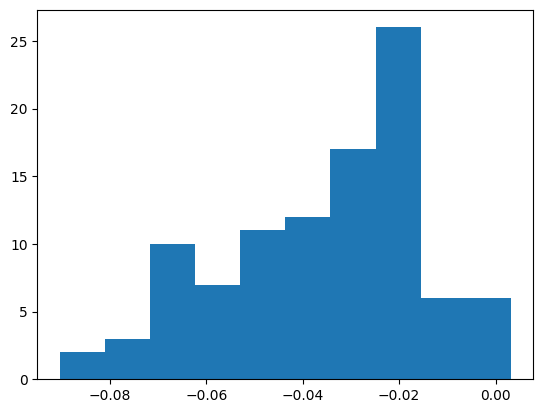

In [45]:
plt.hist(witness_samples)

In [46]:
# reconstructed states, 50 shots per state and meas, 100 monte carlo sample
monte_carlo_samples = 100
shots = 50
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu_ideal, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [05:06<00:00,  3.06s/it]

-0.4325205957638248
0.02376314559172012
-0.4999021132304632
-0.37721341128115005


(array([ 1.,  4.,  6., 11., 14., 26., 16., 13.,  5.,  4.]),
 array([-0.49990211, -0.48763324, -0.47536437, -0.4630955 , -0.45082663,
        -0.43855776, -0.42628889, -0.41402002, -0.40175115, -0.38948228,
        -0.37721341]),
 <BarContainer object of 10 artists>)

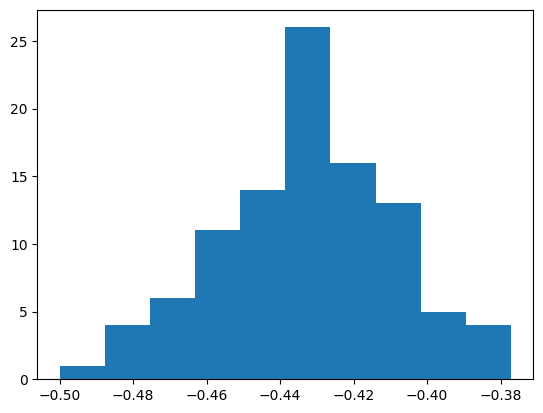

In [48]:
plt.hist(witness_samples)

In [ ]:
#note; devide results by a factor of 512 to achieve proper trace-norm of the witness operator,
#in paper we do so